This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/Desktop

--2021-11-17 10:13:29--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2021-11-17 10:13:29--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucefeb7e6d179a5ff94c58cac375.dl.dropboxusercontent.com/cd/0/inline/BaJ04l6Hi9zi7aMg9O2Uj7MI4ig0L52PT6oABE56wyYXWY1GMEwQxBJhEuA4DVfxPhvQgQdyWpOeYrfj0FnwMptFUt-odUV2G9t869wjsB5W_paW0kM31KNr_qgXvQDqTq8YOXKMoXdH9jo4CYSw_ga8/file# [following]
--2021-11-17 10:13:30--  https://ucefeb7e6d179a5ff94c58cac375.dl.dropboxusercontent.com/cd/0/inline/BaJ04l6Hi9zi7aMg9O2Uj7MI4ig0L52PT6oABE56wyYXWY1GMEwQxBJhEuA4DVfxPhvQgQdyWpOeYr

### 1\. read csv
Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [13]:
import pandas as pd
import numpy as np
datas = "~/Dropbox/Università/Esami in corso/high level programming/data_000637.txt"

df = pd.read_csv(datas, nrows=1e5)
df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25


### 2\. Number of BX
Estimate the number of BX in a ORBIT (the value 'x').

In [24]:
df = pd.read_csv(datas) #we work with the entire dataframe now
#Since the file is very long, we can assume that statistically the counter stops at the equivalent of 59' of an hour at least once, so 1 minute before the new ORBIT
m = df['BX_COUNTER'].max()
print("The maximum number of BX in a ORBIT is:",m)

The maximum number of BX in a ORBIT is: 3563


### 3\. Duration of measurement
Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [21]:
#There are 25ns in each BX, (m+1)*25ns in each ORBIT
df['Time']=25/30*df['TDC_MEAS']+df['BX_COUNTER']*25+(m+1)*25*df['ORBIT_CNT']
measure_time = df['Time'].max()-df['Time'].min() #in ns for 1e5 rows

n_rows = sum(1 for line in open(datas)) #Count number of lines in the txt without loading the whole dataset

print("The measurement of 1e5 records took %.3f seconds" % (measure_time/10**9))

The measurement of 1e5 records took 0.980 seconds


In [22]:
#ALTERNATIVE: sort the whole dataframe and then take first and last row

#By sorting by ORBIT, BX, TDC, we put the highest time at the top and the lowest at the bottom 
df.sort_values(by=['ORBIT_CNT', 'BX_COUNTER','TDC_MEAS'], ascending=False, inplace=True)

def time_conversion(record):
    return 25/30*record['TDC_MEAS']+record['BX_COUNTER']*25+(m+1)*25*record['ORBIT_CNT']

measure_time = time_conversion(df.iloc[0]-df.iloc[-1]) #single record operations
print("The measurement of 1e5 records took %.3f seconds" % (measure_time/10**9))

The measurement of 1e5 records took 0.980 seconds


### 4\. Time column
Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [25]:
#There are 25ns in each BX, (m+1)*25ns in each ORBIT
df['Time']=25/30*df['TDC_MEAS']+df['BX_COUNTER']*25+(m+1)*25*df['ORBIT_CNT'] #Already created in ex 3
df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Time
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14


### 5\. Group by
Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [26]:
ch = df.groupby('TDC_CHANNEL').size().sort_values(ascending=False)
print("The three channel with most signals:\n",ch[:3]) # or ch.head(3), .head also works for series

The three channel with most signals:
 TDC_CHANNEL
139    108059
64      66020
63      64642
dtype: int64


### 6\. Count groups 
Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [29]:
n_orbits = df.groupby(['ORBIT_CNT']).ngroups
ch139 = df[df['TDC_CHANNEL']==139].groupby(['ORBIT_CNT']).ngroups
print("There are %i unique orbits and %i of these are from the ch139" % (n_orbits, ch139))

There are 11001 unique orbits and 10976 of these are from the ch139


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

<AxesSubplot:title={'center':'FPGA=1'}, xlabel='TDC_CHANNEL'>

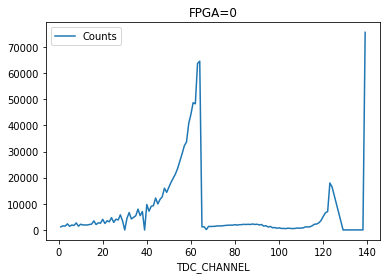

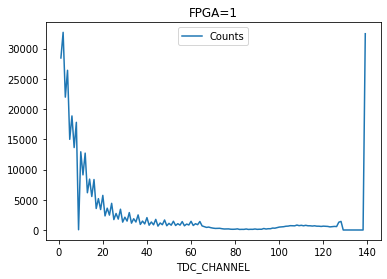

In [31]:
s= df.groupby(['FPGA', 'TDC_CHANNEL']).size().to_frame(name="Counts") #multi-indexing dataframe

s.loc[0].plot(title="FPGA=0")
s.loc[1].plot(title="FPGA=1")